# 图像增广

在[“深度卷积神经网络（AlexNet）”](../chapter_convolutional-neural-networks/alexnet.md)小节里我们提到过，大规模数据集是成功应用深度神经网络的前提。图像增广（image augmentation）技术通过对训练图像做一系列随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模。图像增广的另一种解释是，随机改变训练样本可以降低模型对某些属性的依赖，从而提高模型的泛化能力。例如，我们可以对图像进行不同方式的裁剪，使得感兴趣的物体出现在不同位置，从而让模型减轻对物体出现位置的依赖性。我们也可以调整亮度、色彩等因素来降低模型对色彩的敏感度。可以说，在当年 AlexNet 的成功中，图像增广技术功不可没。本小节我们将讨论这个在计算机视觉里被广泛使用的技术。

首先，导入本节实验所需的包或模块。

In [1]:
%matplotlib inline
import gluonbook as gb
import mxnet as mx
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, utils as gutils
import sys
from time import time

## 常用的图像增广方法

我们来读取一张形状为 $400\times 500$ 的图像作为实验中的样例。

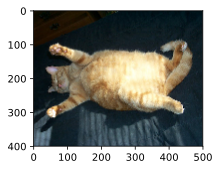

In [2]:
gb.set_figsize()
img = image.imread('../img/cat1.jpg')
gb.plt.imshow(img.asnumpy())

下面定义绘图函数`show_images`。

In [3]:
# 本函数已保存在 gluonbook 包中方便以后使用。
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = gb.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

大部分的图像增广方法都有一定的随机性。为了方便我们观察图像增广的效果，接下来我们定义一个辅助函数`apply`。该函数对输入图像`img`多次运行图像增广方法`aug`并展示所有的结果。

In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

### 翻转和裁剪

左右翻转图像通常不改变物体的类别。它是最早也是最广泛使用的一种图像增广方法。下面我们通过`transforms`模块创建`RandomFlipLeftRight`实例来实现一半几率的图像左右翻转。

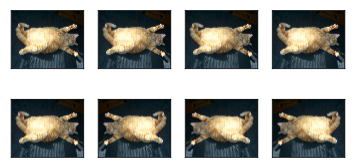

In [5]:
apply(img, gdata.vision.transforms.RandomFlipLeftRight())

上下翻转不如左右翻转通用。但是至少对于样例图像，上下翻转不会造成识别障碍。下面我们创建`RandomFlipTopBottom`实例来实现一半几率的图像上下翻转。

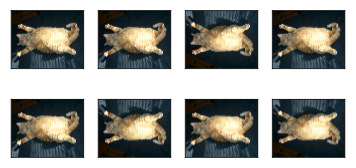

In [6]:
apply(img, gdata.vision.transforms.RandomFlipTopBottom())

在我们使用的样例图像里，猫在图像正中间，但一般情况下可能不是这样。在[“池化层”](../chapter_convolutional-neural-networks/pooling.md)一节里我们解释了池化层能降低卷积层对目标位置的敏感度。除此之外，我们还可以通过对图像随机裁剪来让物体以不同的比例出现在图像的不同位置，这同样能够降低模型对目标位置的敏感性。

在下面的代码里，我们每次随机裁剪出一块面积为原面积 10% 到 100% 的区域，且该区域的宽和高之比随机取自 0.5 和 2 之间，然后再将该区域的宽和高分别缩放到 200 像素。如无特殊说明，本节中 $a$ 和 $b$ 之间的随机数指的是从区间 $[a,b]$ 中均匀采样所得到的连续值。

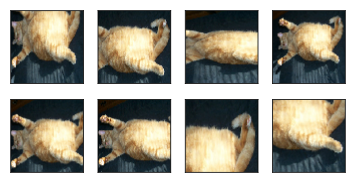

In [7]:
shape_aug = gdata.vision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### 变化颜色

另一类增广方法是变化颜色。我们可以从四个方面改变图像的颜色：亮度、对比度、饱和度和色调。在下面的例子里，我们将图像的亮度随机变化为原图亮度的 50%（$1-0.5$）到 150%（$1+0.5$）之间。

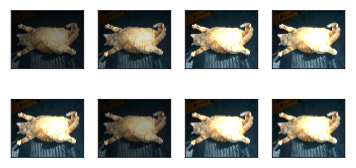

In [8]:
apply(img, gdata.vision.transforms.RandomBrightness(0.5))

类似地，我们也可以随机变化图像的色调。

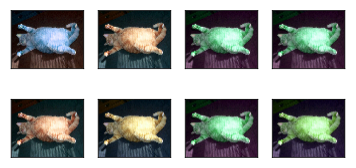

In [9]:
apply(img, gdata.vision.transforms.RandomHue(0.5))

我们也可以创建`RandomColorJitter`实例并同时设置如何随机变化图像的亮度（`brightness`）、对比度（`contrast`）、饱和度（`saturation`）和色调（`hue`）。

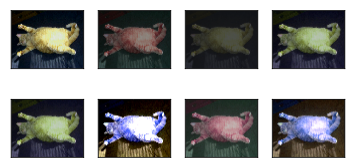

In [10]:
color_aug = gdata.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### 叠加多个图像增广方法

实际应用中我们会将多个图像增广方法叠加使用。我们可以通过`Compose`实例将以上定义的多个图像增广方法叠加起来，再应用到每个图像之上。

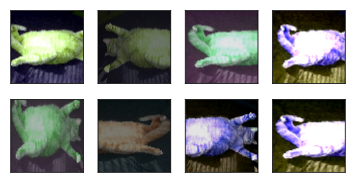

In [11]:
augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])
apply(img, augs)

## 使用图像增广训练模型

下面，我们来看一个将图像增广应用在实际训练中的例子。这里我们使用 CIFAR-10 数据集，而不是之前我们一直使用的 Fashion-MNIST 数据集。这是因为 Fashion-MNIST 数据集中物体的位置和尺寸都已经经过归一化处理，而在 CIFAR-10 数据集中物体的颜色和大小区别更加显著。以下展示了 CIFAR-10 数据集中前 32 张训练图像。

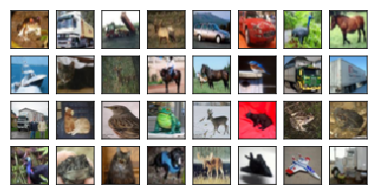

In [12]:
show_images(gdata.vision.CIFAR10(train=True)[0:32][0], 4, 8, scale=0.8);

为了在预测时得到确定的结果，我们通常只将图像增广应用在训练样本上，而不在预测时使用含随机操作的图像增广。在这里我们仅仅使用最简单的随机左右翻转。此外，我们使用`ToTensor`实例将小批量图像转成 MXNet 需要的格式，即形状为（批量大小，通道数，高，宽）、值域在 0 到 1 之间且类型为 32 位浮点数。

In [13]:
flip_aug = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomFlipLeftRight(),
    gdata.vision.transforms.ToTensor()])

no_aug = gdata.vision.transforms.Compose([
    gdata.vision.transforms.ToTensor()])

接下来我们定义一个辅助函数来方便读取图像并应用图像增广。Gluon 的数据集提供的`transform_first`函数将图像增广应用在每个训练样本（图像和标签）的第一个元素，即图像之上。有关`DataLoader`的详细介绍，可参考更早的[“图像分类数据集（Fashion-MNIST）”](../chapter_deep-learning-basics/fashion-mnist.md)一节。

In [14]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size):
    return gdata.DataLoader(
        gdata.vision.CIFAR10(train=is_train).transform_first(augs),
        batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

### 使用多 GPU 训练模型

我们在 CIFAR-10 数据集上训练[“残差网络（ResNet）”](../chapter_convolutional-neural-networks/resnet.md)一节介绍的 ResNet-18 模型。我们还将应用[“多 GPU 计算的 Gluon 实现”](../chapter_computational-performance/multiple-gpus-gluon.md)一节中介绍的方法，使用多 GPU 训练模型。

首先，我们定义`try_all_gpus`函数，从而能够获取所有可用的 GPU。

In [15]:
def try_all_gpus():  # 本函数已保存在 gluonbook 包中方便以后使用。
    ctxes = []
    try:
        for i in range(16):  # 假设一台机器上 GPU 的个数不超过 16。
            ctx = mx.gpu(i)
            _ = nd.array([0], ctx=ctx)
            ctxes.append(ctx)
    except mx.base.MXNetError:
        pass
    if not ctxes:
        ctxes = [mx.cpu()]
    return ctxes

以下定义的辅助函数`_get_batch`将小批量数据样本`batch`划分并复制到`ctx`变量所包含的各个 GPU 上。

In [16]:
def _get_batch(batch, ctx):
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    # 当 ctx 包含多个 GPU 时，划分小批量数据样本并复制到各个 GPU 上。
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx),
            features.shape[0])

然后，我们定义`evaluate_accuracy`函数评价模型的分类准确率。与[“Softmax 回归的从零开始实现”](../chapter_deep-learning-basics/softmax-regression-scratch.md)和[“卷积神经网络（LeNet）”](../chapter_convolutional-neural-networks/lenet.md)两节中描述的`evaluate_accuracy`函数不同，这里定义的函数更加通用：它通过辅助函数`_get_batch`使用`ctx`变量所包含的所有 GPU 来评价模型。

In [17]:
# 本函数已保存在 gluonbook 包中方便以后使用。
def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc = nd.array([0])
    n = 0
    for batch in data_iter:
        features, labels, _ = _get_batch(batch, ctx)
        for X, y in zip(features, labels):
            y = y.astype('float32')
            acc += (net(X).argmax(axis=1) == y).sum().copyto(mx.cpu())
            n += y.size
        acc.wait_to_read()
    return acc.asscalar() / n

接下来，我们定义`train`函数使用多 GPU 训练并评价模型。

In [18]:
# 本函数已保存在 gluonbook 包中方便以后使用。
def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m = 0.0, 0.0, 0.0, 0.0
        start = time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar()
                                 for y_hat, y in zip(y_hats, ys)])
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            trainer.step(batch_size)
            n += batch_size
            m += sum([y.size for y in ys])
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / m, test_acc,
                 time() - start))

现在，我们可以定义`train_with_data_aug`函数使用图像增广来训练模型了。该函数获取了所有可用的 GPU，并将 Adam 作为训练使用的优化算法，然后将图像增广应用于训练数据集之上，最后调用刚才定义的`train`函数训练并评价模型。

In [19]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, ctx, net = 256, try_all_gpus(), gb.resnet18(10)
    net.initialize(ctx=ctx, init=init.Xavier())
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    loss = gloss.SoftmaxCrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=10)

### 有关图像增广的对比实验

我们先观察使用了图像增广的结果。

In [20]:
train_with_data_aug(flip_aug, no_aug)

training on [gpu(0), gpu(1)]


epoch 1, loss 1.3762, train acc 0.512, test acc 0.575, time 38.3 sec


epoch 2, loss 0.8149, train acc 0.711, test acc 0.608, time 35.1 sec


epoch 3, loss 0.6046, train acc 0.790, test acc 0.732, time 35.2 sec


epoch 4, loss 0.4853, train acc 0.830, test acc 0.744, time 35.2 sec


epoch 5, loss 0.3956, train acc 0.863, test acc 0.791, time 35.4 sec


epoch 6, loss 0.3339, train acc 0.885, test acc 0.826, time 35.3 sec


epoch 7, loss 0.2754, train acc 0.904, test acc 0.829, time 35.2 sec


epoch 8, loss 0.2379, train acc 0.917, test acc 0.833, time 35.1 sec


epoch 9, loss 0.2035, train acc 0.930, test acc 0.829, time 35.2 sec


epoch 10, loss 0.1708, train acc 0.941, test acc 0.844, time 35.3 sec


作为对比，下面我们尝试不使用图像增广。

In [21]:
train_with_data_aug(no_aug, no_aug)

training on [gpu(0), gpu(1)]


epoch 1, loss 1.4058, train acc 0.504, test acc 0.523, time 35.4 sec


epoch 2, loss 0.8170, train acc 0.710, test acc 0.693, time 35.2 sec


epoch 3, loss 0.5805, train acc 0.798, test acc 0.762, time 35.2 sec


epoch 4, loss 0.4330, train acc 0.848, test acc 0.745, time 35.3 sec


epoch 5, loss 0.3223, train acc 0.886, test acc 0.790, time 35.3 sec


epoch 6, loss 0.2288, train acc 0.920, test acc 0.748, time 35.2 sec


epoch 7, loss 0.1626, train acc 0.944, test acc 0.794, time 35.2 sec


epoch 8, loss 0.1204, train acc 0.957, test acc 0.801, time 35.1 sec


epoch 9, loss 0.0841, train acc 0.971, test acc 0.810, time 35.3 sec


epoch 10, loss 0.0769, train acc 0.973, test acc 0.809, time 35.3 sec


可以看到，即使添加了简单的随机翻转也可能对训练产生一定的影响。图像增广通常会使训练准确率变低，但有可能提高测试准确率。它可以用来应对过拟合。

## 小结

* 图像增广基于现有训练数据生成随机图像从而应对过拟合。
* 为了在预测时得到确定的结果，我们通常只将图像增广应用在训练样本上，而不在预测时使用含随机操作的图像增广。
* 我们可以从 Gluon 的`transforms`模块中获取有关图片增广的类。

## 练习

* 在基于 CIFAR-10 数据集的模型训练中增加不同的图像增广方法。观察实现结果。
* 查阅 MXNet 文档，Gluon 的`transforms`模块还提供了哪些图像增广方法？

## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/1666)

![](../img/qr_image-augmentation.svg)